In [ ]:
import os
from pathlib import Path
from dataclasses import dataclass

import torch

from gtp.configs.loaders import load_configs
from gtp.configs.project import GenotypeToPhenotypeConfigs
from gtp.dataloading.path_collectors import (
    get_experiment_directory,
    get_post_processed_genotype_directory,
)
from gtp.dataloading.tools import collect_chromosome
from gtp.models.net import SoyBeanNet
from gtp.options.process_attribution import ProcessAttributionOptions

# SPECIFY GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
device = "cuda"


class GeneEditingDashboardState:
    def __init__(
        self,
        wing: str,
        species: str,
        color: str,
        chromosome: int,
        exp_name: str,
        config_path: str,
    ):
        self.wing = wing
        self.species = species
        self.color = color
        self.chromosome = chromosome
        self.exp_name = exp_name
        self.configs: GenotypeToPhenotypeConfigs = load_configs(config_path)
        self.model = None
        self.camids = None
        self.data = None

        self.load_data_and_model()

    def load_data_and_model(self):
        match self.exp_name:
            case "base":
                drop_out_prob = 0.75
                out_dims = 1
                out_dims_start_idx = 0
                insize = 3
                hidden_dim = 10
            case "pca_10":
                drop_out_prob = 0.75
                out_dims = 10
                out_dims_start_idx = 0
                insize = 3
                hidden_dim = 10
            case _:
                raise NotImplementedError(
                    f"Experiment {self.exp_name} isn't implemented for this visualization. Please create a case and update configs."
                )

        opts: ProcessAttributionOptions = ProcessAttributionOptions(
            drop_out_prob=drop_out_prob,
            out_dims=out_dims,
            out_dims_start_idx=out_dims_start_idx,
            insize=insize,
            hidden_dim=hidden_dim,
            species=self.species,
            chromosome=self.chromosome,
            color=self.color,
            wing=self.wing,
            exp_name=self.exp_name,
        )

        processed_genotype_dir = (
            get_post_processed_genotype_directory(self.configs.io)
            / self.configs.experiment.genotype_scope
        )

        # Collect genotype data
        self.camids, self.data = collect_chromosome(
            processed_genotype_dir, self.species, self.chromosome
        )

        self.model = SoyBeanNet(
            window_size=self.data.shape[1],
            num_out_dims=opts.out_dims,
            insize=opts.insize,
            hidden_dim=opts.hidden_dim,
            drop_out_prob=opts.drop_out_prob,
        )

        experiment_dir = get_experiment_directory(
            self.configs.io,
            species=self.species,
            wing=self.wing,
            color=self.color,
            chromosome=self.chromosome,
            exp_name=self.exp_name,
        )

        self.model.load_state_dict(
            torch.load(experiment_dir / "model.pt", weights_only=True)
        )
        self.model = self.model.to(device)
        self.model.eval()


"""
EDIT HERE
"""
gene_editing_dashboard_state = GeneEditingDashboardState(
    wing="forewings",
    species="erato",
    color="color_3",
    chromosome=18,
    exp_name="pca_10",
    config_path=Path("../configs/default.yaml"),
)

In [ ]:
from copy import copy
from dataclasses import dataclass

from ipywidgets import VBox, HBox
import plotly.graph_objs as go
import numpy as np
from captum.attr import LRP
from captum.attr._utils.lrp_rules import GammaRule, EpsilonRule, Alpha1_Beta0_Rule

import math
from collections import defaultdict
from tqdm.auto import tqdm


def get_model_input(camid):
    input_idx = np.where(gene_editing_dashboard_state.camids == camid)[0][0]
    x = gene_editing_dashboard_state.data[input_idx]
    x = torch.tensor(x).unsqueeze(0).unsqueeze(0).float().to(device)
    return x


def get_model_output(input_x):
    with torch.no_grad():
        return gene_editing_dashboard_state.model(input_x)[0]


def get_attr(camid, target=0):
    att_model = LRP(gene_editing_dashboard_state.model)
    att_model.model.block.rule = Alpha1_Beta0_Rule()
    att_model.model.shortcut.rule = Alpha1_Beta0_Rule()
    att_model.model.last_block.rule = Alpha1_Beta0_Rule()
    att_model.model.fc.rule = Alpha1_Beta0_Rule()
    gene_editing_dashboard_state.model.zero_grad()
    x = get_model_input(camid)
    x.requires_grad = True
    attr = att_model.attribute(x, target=target)
    # For LRP, this (ONE-HOT state ex. [0,0,1] attributions) should be sum.
    # This is because the attribution scores should all add up to be the find value in the prediction, so averaging could break that.
    attr = attr.sum(-1)
    attr = attr[0, 0]  # Only has 1 channel, just extract it and is one batch item
    attr = attr.detach().cpu().numpy()

    return attr


In [ ]:
import ipywidgets as widgets


@dataclass
class CurrentGeneState:
    text: str
    index: int


current_gene_state = CurrentGeneState(text="", index=0)

camid_dropdown_widget = widgets.Dropdown(
    options=gene_editing_dashboard_state.camids,
    value=gene_editing_dashboard_state.camids[0],
    description="CAMID",
    disabled=False,
)

num_pca = 10 if gene_editing_dashboard_state.exp_name == "pca_10" else 1
pca_attr_target_widget = widgets.Dropdown(
    options=range(0, num_pca),
    value=0,
    description="PCA Attribution Target",
    disabled=False,
)

current_gene_text_widget = widgets.Text(
    value=current_gene_state.text,
    placeholder="Gene",
    description="Current Gene",
    disabled=True,
    layout=widgets.Layout(width="100%"),
)

edit_btns = widgets.RadioButtons(
    options=["aa", "aA/Aa", "AA", "zero-out"],
)
edit_lbl = widgets.Label(value="Gene Edit")
gene_edit_btns = HBox([edit_lbl, edit_btns])

window_size_dd = widgets.Dropdown(
    options=list(range(0, 100001, 10000)),
    value=0,
    description="Window Size",
    disable=False,
)


def get_edited_input(org_input_x, edit_loc, edit, ws):
    input_x = org_input_x.detach().clone()
    match edit:
        case "AA":
            edit_vec = torch.tensor([0, 0, 1])
        case "Aa/aA":
            edit_vec = torch.tensor([0, 1, 0])
        case "aa":
            edit_vec = torch.tensor([1, 0, 0])
        case "zero-out":
            edit_vec = torch.tensor([0, 0, 0])
        case _:
            pass

    if ws != 0:
        min_idx = max(0, edit_loc - ws)
        max_idx = min(input_x.shape[2], edit_loc + ws)
        edit_vec = edit_vec.unsqueeze(0).repeat(max_idx - min_idx, 1)

    if ws == 0:
        input_x[0][0][edit_loc] = edit_vec
    else:
        input_x[0][0][min_idx:max_idx] = edit_vec

    return input_x


def get_pca_edit_change(camid, ws):
    org_input_x = get_model_input(camid)
    org_model_pca_output = get_model_output(org_input_x)
    edit_options = ["AA", "Aa/aA", "aa", "zero-out"]

    num_of_edits = math.ceil(org_input_x.shape[2] / (ws * 2))
    change_tracker = defaultdict(list)
    for edit_num in tqdm(
        range(num_of_edits), desc="recording changes", colour="#8822CC"
    ):
        x = min((edit_num * ws * 2) + ws, len(manhattan_plot.X))
        current_gene_state.index = x
        current_gene_state.text = f"Position {x}"
        for edit_value in edit_options:
            edited_input_x = get_edited_input(org_input_x, x, edit_value, ws)
            edited_model_pca_output = get_model_output(edited_input_x)
            diff = (edited_model_pca_output - org_model_pca_output).detach().cpu()
            l2_dist = np.sqrt((diff**2).sum()).item()
            change_tracker[x].append((edit_value, l2_dist))

    return change_tracker


class ManhattanPlotInteractive:
    def __init__(self):
        self.display_box = VBox([])
        self.update_data()

    def update_data(self, *args):
        self.camid = camid_dropdown_widget.value
        self.Y = get_attr(self.camid, target=int(pca_attr_target_widget.value))
        self.X = np.arange(len(self.Y))
        window_size = int(window_size_dd.value)
        self.lines = {}
        if window_size > 0:
            change_tracker = get_pca_edit_change(self.camid, window_size)
            self.lines["AA"] = np.array(
                [(k, v[0][1]) for k, v in change_tracker.items()]
            )
            self.lines["Aa/aA"] = np.array(
                [(k, v[1][1]) for k, v in change_tracker.items()]
            )
            self.lines["aa"] = np.array(
                [(k, v[2][1]) for k, v in change_tracker.items()]
            )
            self.lines["zero-out"] = np.array(
                [(k, v[3][1]) for k, v in change_tracker.items()]
            )

        N = 1_000
        top_attr_idx = np.argsort(np.abs(self.Y))[::-1]
        self.top_n_idx = top_attr_idx[:N]
        self.top_X = self.X[self.top_n_idx]
        self.top_Y = self.Y[self.top_n_idx]

        self.update_plot()

    def _update_window_lines(self):
        window_size = int(window_size_dd.value)
        # Remove old lines if they exist
        self.figure_widget.layout.shapes = []
        if window_size > 0:
            gene_loc = current_gene_state.index
            min_x = max(0, gene_loc - window_size)
            max_x = min(len(self.X), gene_loc + window_size)
            # Add new lines
            self.figure_widget.add_vline(x=min_x, line_color="orange")
            self.figure_widget.add_vline(x=max_x, line_color="orange")

    def update_plot(self, *args):
        figure_plots = [
            go.Scatter(x=self.top_X, y=self.top_Y, mode="markers", yaxis="y1")
        ]
        colors = ["red", "purple", "blue", "green"]
        title = "Model Gene Attribution"
        layout = go.Layout(title=title)
        for i, (edit_lbl, data) in enumerate(self.lines.items()):
            figure_plots.append(
                go.Scatter(
                    x=data[:, 0],
                    y=data[:, 1],
                    line_color=colors[i],
                    name=edit_lbl,
                    yaxis="y2",
                )
            )
            layout = go.Layout(
                title=title,
                yaxis=dict(title="Model LRP Attribution"),
                yaxis2=dict(title="Model Edit PCA L2", overlaying="y", side="right"),
            )
        self.figure_widget = go.FigureWidget(data=figure_plots, layout=layout)
        self._update_window_lines()

        # Set Initial Colors
        self.init_colors = ["#0000aa"] * len(self.top_X)
        scatter_plot = self.get_scatter_plot()
        scatter_plot.marker.color = self.init_colors

        # Register on-click events
        scatter_plot.on_click(self.handle_click)

        self.display_box.children = [self.figure_widget]

    def get_scatter_plot(self):
        return self.figure_widget.data[0]

    def handle_click(self, trace, points, state):
        print(points)
        idx = points.point_inds[0]
        x = points.xs[0]
        y = points.ys[0]

        current_gene_state.index = x
        input_x = get_model_input(camid_dropdown_widget.value)
        vec_state = input_x[0][0][x]
        gene_str = ""
        if vec_state[0].item() == 1:
            gene_str = "aa"
        elif vec_state[1].item() == 1:
            gene_str = "aA/Aa"
        if vec_state[2].item() == 1:
            gene_str = "AA"

        current_gene_state.text = f"({gene_str}) | Attribution: ({y}) | Position: ({x})"
        current_gene_text_widget.value = current_gene_state.text

        scatter_plot = self.get_scatter_plot()
        colors = copy(self.init_colors)
        colors[idx] = "#ff0000"
        with self.figure_widget.batch_update():
            scatter_plot.marker.color = colors

        self._update_window_lines()


manhattan_plot = ManhattanPlotInteractive()

camid_dropdown_widget.observe(manhattan_plot.update_data, "value")
pca_attr_target_widget.observe(manhattan_plot.update_data, "value")
window_size_dd.observe(manhattan_plot.update_data, "value")

/home/carlyn.1/miniconda3/envs/gtp/lib/python3.10/site-packages/torch/nn/modules/conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv2d(


recording changes:   0%|          | 0/83 [00:00<?, ?it/s]

recording changes:   0%|          | 0/83 [00:00<?, ?it/s]

recording changes:   0%|          | 0/83 [00:00<?, ?it/s]

recording changes:   0%|          | 0/83 [00:00<?, ?it/s]

recording changes:   0%|          | 0/83 [00:00<?, ?it/s]

recording changes:   0%|          | 0/83 [00:00<?, ?it/s]

recording changes:   0%|          | 0/83 [00:00<?, ?it/s]

recording changes:   0%|          | 0/83 [00:00<?, ?it/s]

In [4]:
change_tracker = get_pca_edit_change(manhattan_plot.camid, 1000)

recording changes:   0%|          | 0/824 [00:00<?, ?it/s]

/home/carlyn.1/tmp/ipykernel_1679635/1676706288.py:88: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



In [ ]:
import plotly.graph_objs as go

lines = {}
lines["AA"] = np.array([(k, v[0][1]) for k, v in change_tracker.items()])
lines["Aa/aA"] = np.array([(k, v[1][1]) for k, v in change_tracker.items()])
lines["aa"] = np.array([(k, v[2][1]) for k, v in change_tracker.items()])
lines["zero-out"] = np.array([(k, v[3][1]) for k, v in change_tracker.items()])

colors = ["red", "green", "blue", "purple"]
data_figs = []
for i, (k, v) in enumerate(lines.items()):
    data_figs.append(go.Scatter(x=v[:, 0], y=v[:, 1], name=k, line_color=colors[i]))

my_fig = go.FigureWidget(data=data_figs)
my_fig

FigureWidget({
    'data': [{'line': {'color': 'red'},
              'name': 'AA',
              'type': 'scatter',
              'uid': 'e8859b7f-68a7-4781-b02c-8d00d856b94b',
              'x': array([1.000000e+03, 3.000000e+03, 5.000000e+03, ..., 1.643000e+06,
                          1.645000e+06, 1.646818e+06], shape=(824,)),
              'y': array([0.20460452, 0.09932753, 0.19927049, ..., 0.07110463, 0.2003502 ,
                          0.21990913], shape=(824,))},
             {'line': {'color': 'green'},
              'name': 'Aa/aA',
              'type': 'scatter',
              'uid': 'a4e96982-eeaf-49db-a0f3-e8910b45f63b',
              'x': array([1.000000e+03, 3.000000e+03, 5.000000e+03, ..., 1.643000e+06,
                          1.645000e+06, 1.646818e+06], shape=(824,)),
              'y': array([0.13256492, 0.32064605, 0.10204381, ..., 0.19035444, 0.18667085,
                          0.07919893], shape=(824,))},
             {'line': {'color': 'blue'},
         

In [6]:
display(camid_dropdown_widget)
display(pca_attr_target_widget)
display(window_size_dd)
display(manhattan_plot.display_box)

Dropdown(description='CAMID', options=(np.str_('CAM016019'), np.str_('CAM016020'), np.str_('CAM016021'), np.st…

Dropdown(description='PCA Attribution Target', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0)

Dropdown(description='Window Size', options=(0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000,…

    'data': [{'marker': {'color': [#0000aa, #0000aa, #0000aa, ..., #0000aa,
    …

### Why are the LRP attributions not aligned with the editing attributions?
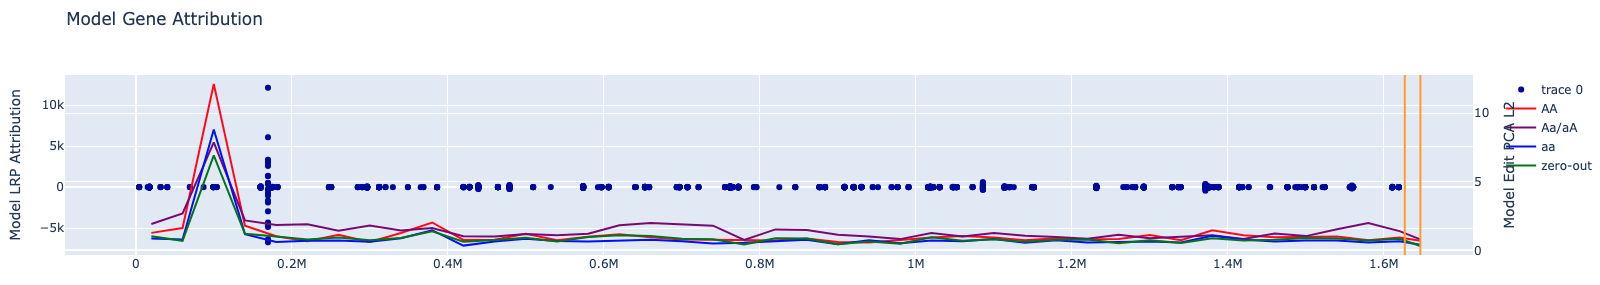

In [ ]:
from captum.attr._utils.lrp_rules import GammaRule, EpsilonRule, Alpha1_Beta0_Rule


def get_attr_test(camid, target=0):
    att_model = LRP(gene_editing_dashboard_state.model)
    gene_editing_dashboard_state.model.zero_grad()
    x = get_model_input(camid)
    x.requires_grad = True
    attr, delta = att_model.attribute(x, target=target, return_convergence_delta=True)
    # For LRP, this (ONE-HOT state ex. [0,0,1] attributions) should be sum.
    # This is because the attribution scores should all add up to be the find value in the prediction, so averaging could break that.
    attr = attr.sum(-1)
    attr = attr[0, 0]  # Only has 1 channel, just extract it and is one batch item
    attr = attr.detach().cpu().numpy()

    return attr, delta


attr, delta = get_attr_test(
    manhattan_plot.camid, target=int(pca_attr_target_widget.value)
)

In [8]:
delta

tensor([982.9927], device='cuda:0', grad_fn=<SubBackward0>)

In [9]:
pca_idx = 0
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.plot(gene_editing_dashboard_state.model.fc.weight[pca_idx].detach().cpu().numpy())

NameError: name 'plt' is not defined

In [ ]:
hook = None

(tensor([[-0.1025,  0.2638, -0.1725,  ..., -0.0931,  0.0608,  0.0412]],
       device='cuda:0'),)


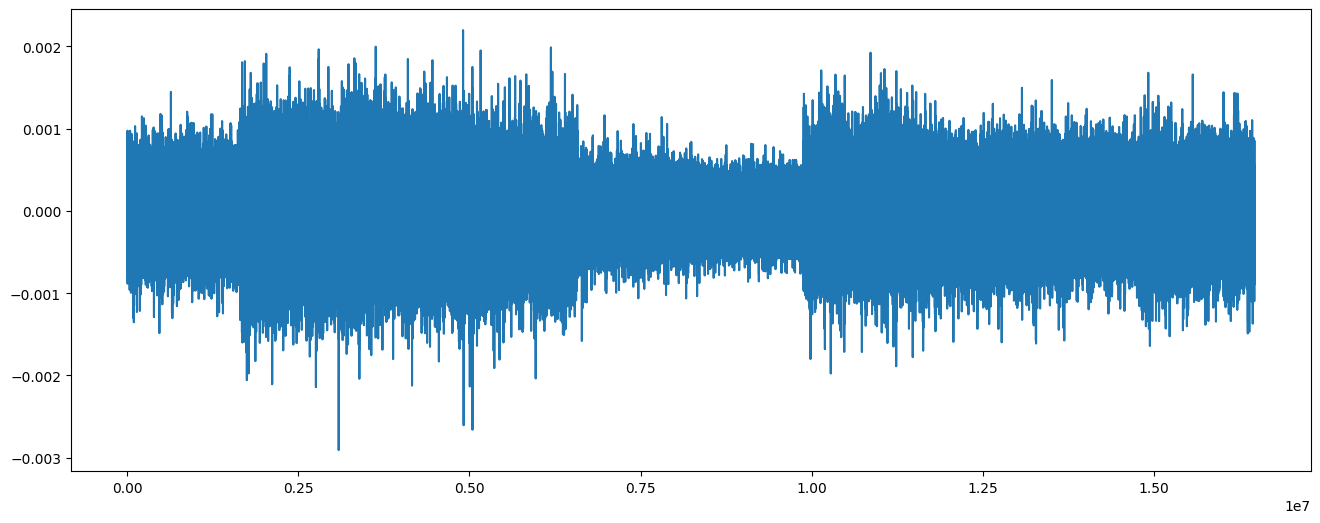

In [ ]:
activation_out = {}
activation_in = {}
if hook is not None:
    hook.remove()


def get_activation(name):
    def hook(model, input, output):
        activation_out[name] = output.detach()
        activation_in[name] = input[0].detach()

    return hook


hook = gene_editing_dashboard_state.model.fc.register_forward_hook(get_activation("fc"))

x = get_model_input(camid_dropdown_widget.value)
y = get_model_output(x)


fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.plot(
    activation_in["fc"][0].detach().cpu().numpy()
    * gene_editing_dashboard_state.model.fc.weight[0].detach().cpu().numpy()
)

In [ ]:
activation_in["fc"]

torch.Size([1, 16468150])

### Is Dropout causing issues with attribution?

### Is the larger feature size at the end an issue?